## Imports

In [12]:
import numpy as np
import time
import datetime
import random

from keras.callbacks import LambdaCallback
from keras.utils import plot_model
from keras.callbacks import TensorBoard

from pandas import read_csv
from Audio.Components.MidiPlayer import MidiPlayer

from keras.utils.vis_utils import model_to_dot
from keras.callbacks import LearningRateScheduler
from matplotlib import pyplot
from IPython.display import SVG
import pydot
import graphviz

from NN.networks.windowed_model import create_model
# from NN.models.separate_model import create_model

from Audio.Components.helpers.prepare_arrays import prepare_notes, prepare_lengths
from Audio.Components.helpers.save_model import save_model
from Audio.Components.helpers.make_encoded_prediction import make_encoded_prediction
from Audio.Components.helpers.create_categorical_indicies import create_category_indicies
from Audio.Components.helpers.generate_phrases import generate_phrases
from Audio.Components.helpers.decode_predictions import decode_predictions
from Audio.Components.helpers.play_generated_phrase import play_generated_phrase
from Audio.Components.helpers.vectorize_phrases import vectorize_phrases
from Audio.Components.helpers.logger import logger
import constants

## Constants

In [33]:
player = MidiPlayer()
dropout = 0.5
n_time_steps = constants.n_time_steps
semi_redundancy_step = constants.semi_redundancy_step
lstm_size = 16
lr = constants.lr
epochs = constants.epochs
batch_size = constants.batch_size
n_to_generate = constants.n_to_generate

['IAC Driver Bus 1', 'IAC Driver LocalMidi']


In [34]:
logger('PREPROCESSING')
corpus = read_csv('Audio/data/input.csv', header=1)
print('corpus length:', len(corpus))
notes_corpus = corpus.values[:, 0]
length_corpus = corpus.values[:, 1]

          **********************************
            PREPROCESSING
          **********************************
corpus length: 32440


In [35]:
categorized_variables = {
    'note_categories': prepare_notes(),
    'length_categories': prepare_lengths()
}

In [36]:
note_index, index_note = create_category_indicies(categorized_variables['note_categories'])
lengths_index, index_lengths = create_category_indicies(categorized_variables['length_categories'])

lookup_indicies = {
    'note_index': note_index,
    'index_note': index_note,
    'lengths_index': lengths_index,
    'index_lengths': index_lengths,
}

note_phrases, next_note = generate_phrases(notes_corpus, n_time_steps, semi_redundancy_step)
length_phrases, next_length = generate_phrases(length_corpus, n_time_steps, semi_redundancy_step)
print(note_phrases[0:10])

[[62. 58. 57.  0. 69. 67. 63. 62.  0. 68. 65. 61. 60.  0. 66. 63. 59. 58.
   0. 65. 62. 58. 57.  0. 64.  0. 64. 61. 57. 56.]
 [58. 57.  0. 69. 67. 63. 62.  0. 68. 65. 61. 60.  0. 66. 63. 59. 58.  0.
  65. 62. 58. 57.  0. 64.  0. 64. 61. 57. 56. 60.]
 [57.  0. 69. 67. 63. 62.  0. 68. 65. 61. 60.  0. 66. 63. 59. 58.  0. 65.
  62. 58. 57.  0. 64.  0. 64. 61. 57. 56. 60. 57.]
 [ 0. 69. 67. 63. 62.  0. 68. 65. 61. 60.  0. 66. 63. 59. 58.  0. 65. 62.
  58. 57.  0. 64.  0. 64. 61. 57. 56. 60. 57. 53.]
 [69. 67. 63. 62.  0. 68. 65. 61. 60.  0. 66. 63. 59. 58.  0. 65. 62. 58.
  57.  0. 64.  0. 64. 61. 57. 56. 60. 57. 53. 52.]
 [67. 63. 62.  0. 68. 65. 61. 60.  0. 66. 63. 59. 58.  0. 65. 62. 58. 57.
   0. 64.  0. 64. 61. 57. 56. 60. 57. 53. 52. 58.]
 [63. 62.  0. 68. 65. 61. 60.  0. 66. 63. 59. 58.  0. 65. 62. 58. 57.  0.
  64.  0. 64. 61. 57. 56. 60. 57. 53. 52. 58. 55.]
 [62.  0. 68. 65. 61. 60.  0. 66. 63. 59. 58.  0. 65. 62. 58. 57.  0. 64.
   0. 64. 61. 57. 56. 60. 57. 53. 52. 58. 55. 51.]


In [37]:
note_x, note_y = vectorize_phrases(
    phrases=note_phrases,
    n_categories=len(categorized_variables['note_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['note_index'],
    next_lookup_index=next_note
    )

length_x, length_y = vectorize_phrases(
    phrases=length_phrases,
    n_categories=len(categorized_variables['length_categories']),
    n_time_steps=n_time_steps,
    lookup_index=lookup_indicies['lengths_index'],
    next_lookup_index=next_length
)

print(note_x.shape, 'note_x.shape')
print(length_x.shape, 'length_x.shape')
print(note_y.shape, 'note_y.shape')
print(length_y.shape, 'length_y.shape')

(32410, 30, 128) note_x.shape
(32410, 30, 141) length_x.shape
(32410, 128) note_y.shape
(32410, 141) length_y.shape


In [38]:
model = create_model(
    categorized_variables=categorized_variables,
    lstm_size=lstm_size,
    lr=0.001,
    n_time_steps=n_time_steps,
    dropout=dropout,
)

In [39]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
note_input (InputLayer)         (None, 30, 128)      0                                            
__________________________________________________________________________________________________
length_input (InputLayer)       (None, 30, 141)      0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 30, 32)       18560       note_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 30, 32)       20224       length_input[0][0]               
__________________________________________________________________________________________________
dropout_5 

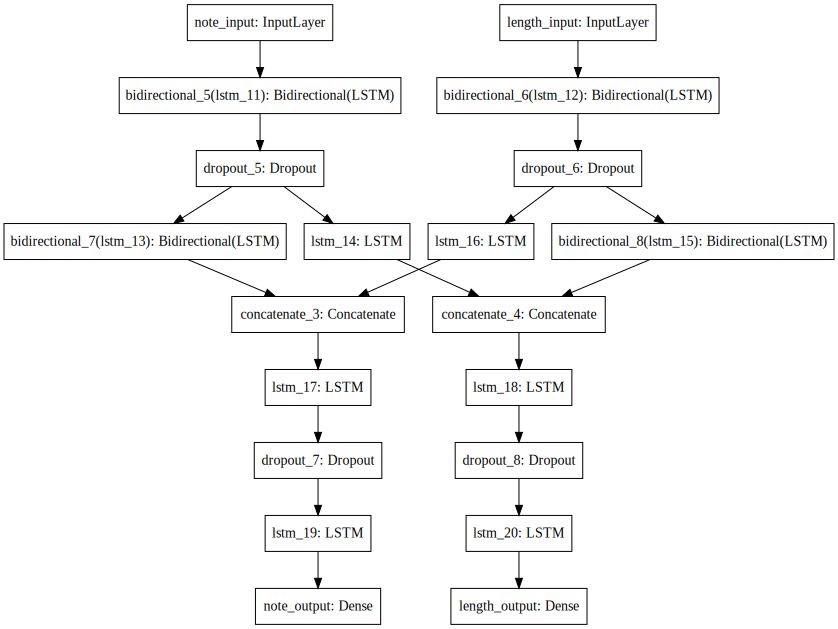

In [40]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [41]:
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.6
	epochs_drop = 25
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [42]:
def listen_callback(epoch, logs):
    if epoch % 20 == 0 and epoch > -1: 
    # if epoch < -2:
        print('----- Generating melody after Epoch: %d' % epoch)
        
        start_index = random.randint(0, 7000)
        for diversity in [0.5]:
            print('----- diversity:', diversity)

            current_note_phrase = notes_corpus[start_index: start_index + n_time_steps]
            current_length_phrase = length_corpus[start_index: start_index + n_time_steps]

            phrases = {'note_phrase': current_note_phrase, 'length_phrase': current_length_phrase}

            generated_notes = []
            generated_lengths = []
            generated_notes.extend(current_note_phrase)
            generated_lengths.extend(current_length_phrase)

            # model, phrases,categorized_variables, lookup_indicies, n_time_steps, diversity, n_to_generate
            for step in range(70):
                encoded_prediction = make_encoded_prediction(
                    model=model,
                    phrases=phrases,
                    categorized_variables=categorized_variables,
                    lookup_indicies=lookup_indicies,
                    n_time_steps=n_time_steps
                )

                predictions = decode_predictions(
                    encoded_prediction=encoded_prediction,
                    lookup_indicies=lookup_indicies,
                    temperature=diversity
                )

                generated_notes.append(predictions['note_prediction']) 
                generated_lengths.append(predictions['length_prediction']) 

                phrases['note_phrase'] = np.append(phrases['note_phrase'][1:], predictions['note_prediction'])
                phrases['length_phrase'] = np.append(phrases['length_phrase'][1:], predictions['length_prediction'])

            play_generated_phrase(
                generated_notes=generated_notes[10:],
                generated_lengths=generated_lengths[10:],
                player=player)

In [43]:
lrate = LearningRateScheduler(step_decay)

In [44]:
tensorboard = TensorBoard(log_dir="./logs/{}".format(datetime.datetime.now()), histogram_freq=0, write_graph=True)

In [45]:
listen_callback = LambdaCallback(on_epoch_end=listen_callback)

In [ ]:
logger('TRAINING')
model.fit([note_x, length_x], [note_y, length_y],
          batch_size=batch_size,
          epochs=300,
          callbacks=[
              listen_callback,
#               tensorboard,
            ]
          )

          **********************************
            TRAINING
          **********************************
Epoch 1/300
 8960/32410 [=======>......................] - ETA: 54s - loss: 6.6040 - note_output_loss: 4.3553 - length_output_loss: 4.4975

In [ ]:
save_model(model, 'model_2')